In [1]:
import pathlib
import sys
sys.path.append("..")
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from utils import load_image_as_array, get_metadata_sample, plot_images, predict_image, plot_prediction

2023-08-27 21:03:22.098618: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 21:03:22.137666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 21:03:22.705114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Exploring chest x-ray labels

In [2]:
data_dir = pathlib.Path("../data")
labels = pd.read_csv(data_dir / "labels.csv")
labels.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [3]:
print("##### LABELS #####")
labels["label"].value_counts()

##### LABELS #####


label
No Finding      980
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: count, dtype: int64

# View particular chest x-ray label

In [4]:
IMG_HEIGHT, IMG_WIDTH = 256, 256

In [5]:
POS_LABEL = "Cardiomegaly"
NEG_LABEL = "No Finding"

pos_sample = get_metadata_sample(labels, POS_LABEL)
neg_sample = get_metadata_sample(labels, NEG_LABEL)

In [6]:
IMG_DIR = data_dir / "images"
pos_imgs = [load_image_as_array(IMG_DIR / img_file, IMG_HEIGHT, IMG_WIDTH) for img_file in pos_sample["filename"]]
neg_imgs = [load_image_as_array(IMG_DIR / img_file, IMG_HEIGHT, IMG_WIDTH) for img_file in neg_sample["filename"]]

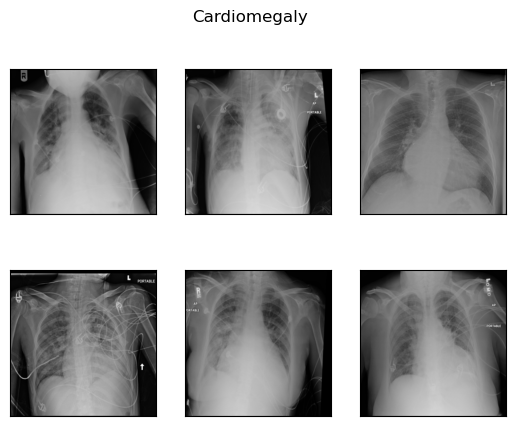

In [7]:
plot_images(pos_imgs, POS_LABEL)

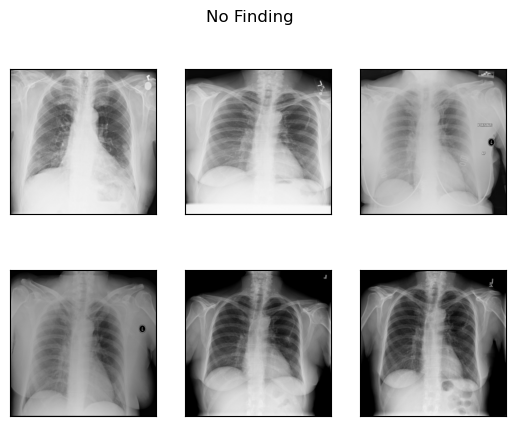

In [8]:
plot_images(neg_imgs, NEG_LABEL)

# Evaluate trained model

In [9]:
MODEL_PATH = pathlib.Path("..") / "model.keras"
model = tf.keras.models.load_model(MODEL_PATH)

2023-08-27 21:03:33.517216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 21:03:33.538785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 21:03:33.538929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
test_dir = data_dir / "test"
test_pos_dir, test_neg_dir = test_dir / "positive", test_dir / "negative"

## 1. Positive examples

In [11]:
test_results = []
for file in test_pos_dir.iterdir():
    logit, pred = predict_image(file, model, IMG_HEIGHT, IMG_WIDTH)
    test_results.append((file, "pos", pred, logit))

2023-08-27 21:04:05.640797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 0s 20ms/step


2023-08-27 21:04:06.240507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 19ms/step


# 2. Negative examples

In [12]:
for file in test_neg_dir.iterdir():
    logit, pred = predict_image(file, model, IMG_HEIGHT, IMG_WIDTH)
    test_results.append((file, "neg", pred, logit))

1/1 [==============================] - 0s 19ms/step


In [13]:
# sort results by confidence
sorted_results = sorted(test_results, key=lambda x: x[3], reverse=True)

results_df = pd.DataFrame(sorted_results, columns=["filename", "label", "pred", "confidence"])
results_df.head(10)

,filename,label,pred,confidence
0,../data/test/positive/00004893_085.jpg,pos,pos,0.991073
1,../data/test/positive/00014223_009.jpg,pos,pos,0.980938
2,../data/test/positive/00028018_000.jpg,pos,pos,0.974013
3,../data/test/positive/00020819_002.jpg,pos,pos,0.973374
4,../data/test/positive/00004533_014.jpg,pos,pos,0.969627
5,../data/test/positive/00014574_000.jpg,pos,pos,0.967456
6,../data/test/negative/00000167_000.jpg,neg,pos,0.964136
7,../data/test/positive/00007551_020.jpg,pos,pos,0.963640
8,../data/test/positive/00028607_000.jpg,pos,pos,0.948371
9,../data/test/positive/00022706_001.jpg,pos,pos,0.931685


# 3. Plot some results

## 3a. True positive

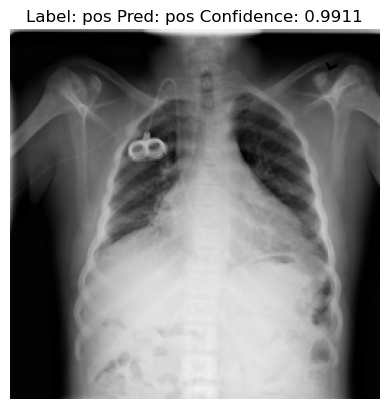

In [14]:
idx = 0
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

## 3b. True negative

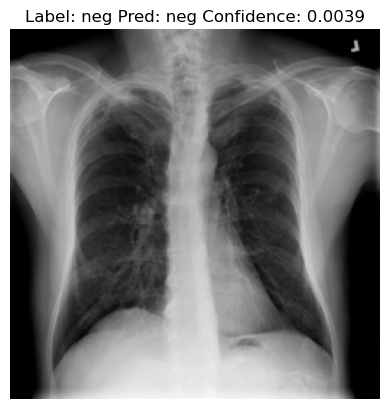

In [15]:
idx = len(results_df) - 1
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

# 3c. False positive

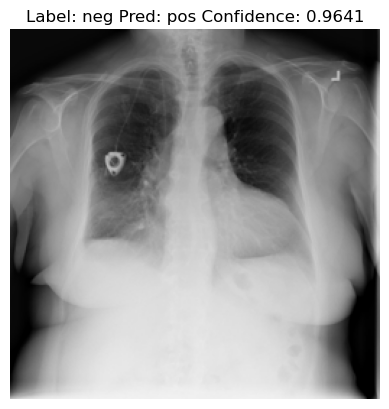

In [17]:
idx = 6
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

# 4. False negative

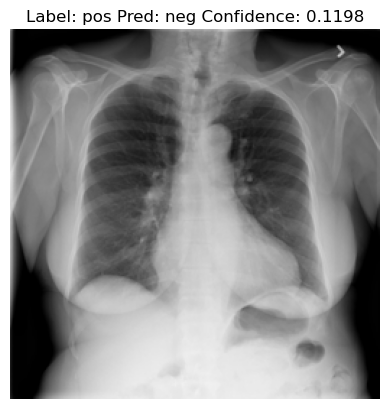

In [20]:
idx = 49
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

# 4. Model confidence

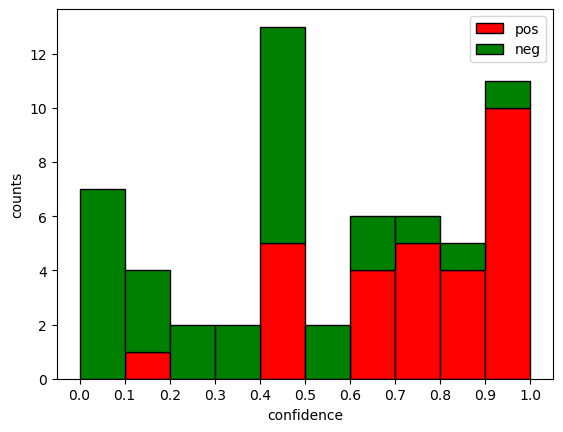

In [21]:
pos_df = results_df[results_df["label"] == "pos"]
neg_df = results_df[results_df["label"] == "neg"]

n, bins, patches = plt.hist((pos_df["confidence"], neg_df["confidence"]), np.arange(0.0, 1.1, 0.1),
    edgecolor="black", stacked=True, color=["red", "green"], label=["pos", "neg"])
plt.xlabel("confidence")
plt.ylabel("counts")
plt.xticks(bins)
plt.legend(loc="upper right")
plt.show()

# 5. AUC/ROC Curve

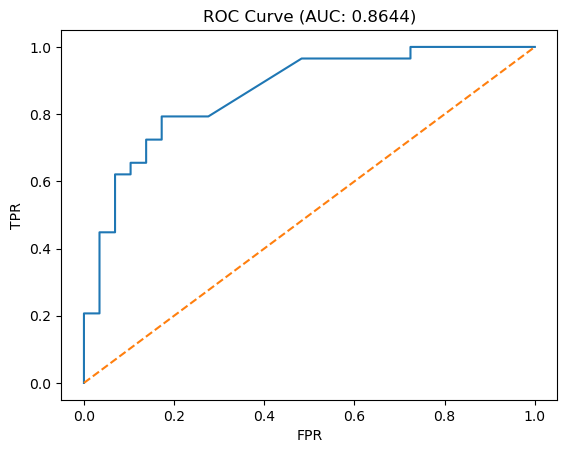

In [22]:
confidences = results_df["confidence"].values
labels = results_df["label"].map({"neg":0, "pos":1}).values

fpr, tpr, thresholds= roc_curve(labels, confidences)
auc = roc_auc_score(labels, confidences)

plt.plot(fpr, tpr)
plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC Curve (AUC: {auc:.4f})")
plt.show()